# Convolutional neural networks with TensorFlow Keras

### Steps
1. Import the necessary packages
2. Get the data
3. Set up the network architecture
4. Train the network 
5. Hyperparameter tuning
6. Use the trained network



### Import the necessary packages

In [ ]:
import numpy as np
import os
import time
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, initializers, Model, models, optimizers, metrics, callbacks, regularizers
from functools import partial
from sklearn.metrics import multilabel_confusion_matrix

### Get the data

In [ ]:
# load the mnist dataset, already split in training and test data
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data() 
# http://yann.lecun.com/exdb/mnist/
x_train.shape, y_train.shape, x_test.shape, y_test.shape

### Preprocess the data - this time we keep the images as images

In [ ]:
# preprocess the images
input_shape = (28, 28, 1)  # image shape, 1 denotes the number of colour channels: greyscale has one channel

# scale images to the range between 0 and 1
print('original pixel value', x_train[0,5,14])
x_train = x_train.astype("float32") / 255
x_test = x_test.astype("float32") / 255
print('normalised pixel value', x_train[0,5,14])

# Make sure images have shape (28, 28, 1)
print('original X shape', x_train.shape)
x_train = np.expand_dims(x_train, -1)
x_test = np.expand_dims(x_test, -1)
print('X shape with colour channel', x_train.shape)

input_shape = x_train.shape[1:]  # image shape, 1 denotes the number of colour channels: greyscale has one channel
print('input shape: ', input_shape)

In [ ]:
# preprocess the labels (0..9)
num_classes = len(set(y_train))  # 10 classes, one for each digit

# use one-hot encoding to binarise the labels
print('label (shown digit): ', y_train[0])
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)
print('one-hot encoded label', y_train[0])

## Set up the convolutional neural network

https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv2D

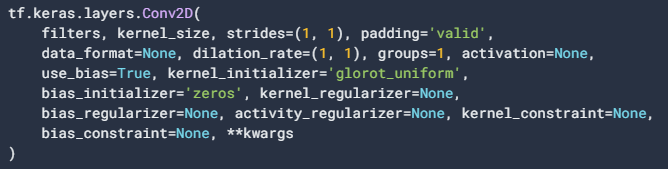


### Set up the layers

Note:
- padding='same' is zero padding. 'valid' results in no padding, thus rows/columns of the feature map may be ignored depending on the kernel and stride and the resulting feature map is smaller

In [ ]:
l2_regulariser = regularizers.l2(0.0001)

denseLayer = partial(layers.Dense, use_bias=False,
                     kernel_initializer='he_normal',
                     kernel_regularizer=l2_regulariser,
                     activation='relu')

convLayer = partial(layers.Conv2D, kernel_size=3, use_bias=False, padding='same',  
                    kernel_initializer='he_normal',
                    kernel_regularizer=l2_regulariser,
                    activation='relu')

batchLayer = partial(layers.BatchNormalization, center=True, scale=False)  # scale can be disabled when using ReLU

poolLayer = partial(layers.MaxPooling2D, pool_size=(2, 2))

### Set up the network architecture

In [ ]:
# network architecture
input_ = layers.Input(shape=input_shape)  

# conv part
conv_1_1 = convLayer(filters=64)(input_)
batch_1_1 = batchLayer()(conv_1_1)

conv_1_2 = convLayer(filters=64)(batch_1_1)
batch_1_2 = batchLayer()(conv_1_2)
pool_1 = poolLayer()(batch_1_2)

conv_2_1 = convLayer(filters=128)(pool_1)
batch_2_1 = batchLayer()(conv_2_1)

conv_2_2 = convLayer(filters=128)(batch_2_1)
batch_2_2 = batchLayer()(conv_2_2)

conv_2_3 = convLayer(filters=128)(batch_2_2)
batch_2_3 = batchLayer()(conv_2_3)
pool_2 = poolLayer()(batch_2_3)

flat = layers.Flatten()(pool_2)  # alternatively layers.GlobalAveragePooling2D()(pool_2)
drop_flat = layers.Dropout(0.1)(flat)

dense_1 = denseLayer(500)(drop_flat)  
batch_d_1 = batchLayer()(dense_1)
drop_1 = layers.Dropout(0.5)(batch_d_1)

dense_2 = denseLayer(500)(drop_1)  
batch_d_2 = batchLayer()(dense_2)
drop_2 = layers.Dropout(0.5)(batch_d_2)

output = denseLayer(num_classes, activation='softmax')(drop_2)  

model = Model(inputs=[input_], outputs=[output])

# print the architecture
model.summary()

### Set up network training

Note that you need to run the model setup again, otherwise training gets mixed up 

In [ ]:
tensorboard_path = os.path.join('tensorboard/', time.strftime('%d_%m_%y-%H_%M'))
# train the network 
learning_rate = .0001 # 0.001 is the default learning rate for adam
batch_size = 128
epochs = 50
adam = tf.keras.optimizers.RMSprop(learning_rate=learning_rate)

# to start tensorboard via console within the folder >> tensorboard --logdir=./tensorboard --port=6006
tensorboard_cb = callbacks.TensorBoard(tensorboard_path)
checkpoint_cb = callbacks.ModelCheckpoint('tuned_network', save_best_only=True, monitor='val_accuracy', mode='max')
early_stopping_cb = callbacks.EarlyStopping(patience=5)

model.compile(loss="categorical_crossentropy", optimizer=adam, 
              metrics=["accuracy", metrics.Precision(), metrics.Recall()])

history = model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, validation_split=0.2, 
                    callbacks=[checkpoint_cb, tensorboard_cb])  # early_stopping_cb
print('test')
model.evaluate(x_test, y_test)

### Precision & Recall

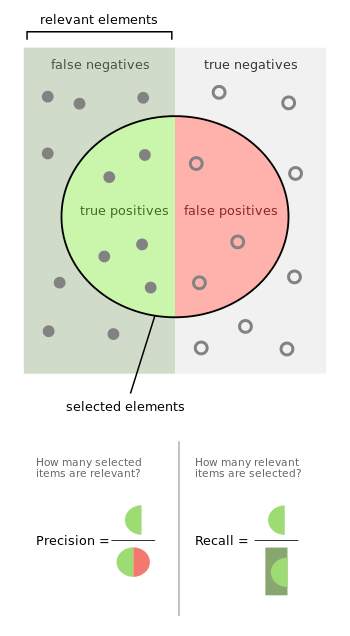

Precision: validity  
Recall: completeness, sensitivity

F1 score: $ 2 * \frac{precision * recall}{precision + recall} $ (harmonic mean of the precision and recall)

In [ ]:
# Analyse the results

print('Model metrics: ', model.metrics_names)  
print('Run the trained network with the test data: ')
test_run = model.evaluate(x_test, y_test)

# compute the F1 score
# depending on how often you run the network using a Jupyter notebook metrics might be named name_1 etc.
precision = history.history['val_precision'][-1] 
recall = history.history['val_recall'][-1] 
f1_val = 2 * (precision * recall) / (precision + recall)
f1_test = 2 * (test_run[2] * test_run[3]) / (test_run[2] + test_run[3])

print('Test results: ', test_run)
print('F1 score validation: ', f1_val)
print('F1 score test: ', f1_test)


### Confusion matrix
Compute a one-vs-rest confusion matrix for all class categories using the saved, best network from hyperparameter tuning

In [ ]:
model = models.load_model('tuned_network')
predictions = model.predict(x_test)

confusion_matrix = multilabel_confusion_matrix(y_test, tf.where(predictions <= 0.5, 0, 1))
confusion_matrix

### Excercises
- Download and prepare the fashion MNIST dataset (https://keras.io/api/datasets/fashion_mnist/)
- Set up your own convolutional neural network on Google Colab
- Tune the number of layers, learning rate, optimiser, etc. and monitor the changes in the learning performance via Tensorboard 
